# Step 1: Read in the Data and Packages

Packages

In [2]:
# General
import pandas as pd
import numpy as np
from nltk import word_tokenize
import re
from string import punctuation 
from nltk.corpus import stopwords
import nltk 
#nltk.download('wordnet') # Downloads the WordNetLemmatizer package
from nltk.stem import WordNetLemmatizer 
import re

#Word Cloud
from os import path
from PIL import Image
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Oversample
from sklearn.utils import resample
import dataframe_image as dfi

# Train Test Split
from sklearn.model_selection import train_test_split

#Models and Performance Metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
sns.set() 

# Neural Networks
import torch
import torchtext
from torchtext.legacy import data #For handling text data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


The Dataset being used is the COVID-19 Rumours Dataset (Cheng, M., Wang, S., Yan, X., Yang, T., Wang, W., Huang, Z., Xiao, X., Nazarian, S., & Bogdan, P. (2021). A COVID-19 Rumor Dataset. Frontiers in Psychology, 12. https://doi.org/10.3389/fpsyg.2021.644801)

In [3]:
url = 'https://raw.githubusercontent.com/MickeysClubhouse/COVID-19-rumor-dataset/master/Data/en_dup.csv'
df = pd.read_csv(url)
df = df.drop(columns=['source', 'author', 'time',])
df.rename(columns={'label': 'veracity', 'content': 'text'}, inplace=True)
df

,veracity,text
0,F,Coronavirus was created in a government lab as...
1,F,The lie that coronavirus came from a bat or a ...
2,F,The health experts had predicted the virus cou...
3,F,A video clip supposedly showed that the expone...
4,T,Almost 200 people in Italy died from the coron...
...,...,...
7174,F,“DDP (Democratic Progressive Party) legislator...
7175,F,"In Japan, if the new coronavirus test is negat..."
7176,T,We have a perfectly coordinated and fine tuned...
7177,F,Official death toll over 900 but we all know t...


Save to CSV if needed

In [4]:
#df.to_csv('Covid Rumours.csv', index=False)

Relabel Veracity to true, false and unverified

In [5]:
df['veracity'] = df['veracity'].map({"F":"False","T":"True", "U":"Unverified"})

Drop unverified for binary classification task

In [6]:
df.drop(df.index[df['veracity'] == 'Unverified'], inplace = True)

Check Class distributions prior to preprocessing

In [7]:
print("The Percentage of classes are:")
print(df['veracity'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\n")
print("The Number of classes are:")
print(df['veracity'].value_counts())

The Percentage of classes are:
False    66.2%
True     33.8%
Name: veracity, dtype: object


The Number of classes are:
False    3681
True     1878
Name: veracity, dtype: int64


# Step 2: PreProcess the Data

Split X (text) and Y (veracity)

In [8]:
veracity = df["veracity"].tolist()
text = df["text"].tolist()

#Check the length of samples for debugging purposes
print(len(veracity))
print(len(text))

5559
5559


1: Remove stopwords, lowercase and tokenize

In [9]:
stopwords_english = stopwords.words('english') 

In [10]:
# Adding Extra words to the stopoword corpus
f = "say"
stopwords_english.append(f)
l = "get"
stopwords_english.append(l)

In [88]:
veracity_token = []
text_token = []

#Printing the 7th text out to see change in processes. Here this is 
# the text before preprocessing
print("Text 7:", text[7])
print("Veracity 7:", veracity[7])


Text 7: n
Veracity 7: False


In [12]:
print("Tokenising text...", end="")
for i in range(len(text)):
    try:
        tokens = word_tokenize(text[i].lower())#break up sentence to individual words
        stopwords_removed = [k for k in tokens if k not in stopwords_english]
        if(len(stopwords_removed)>1):  
            text_token.append(stopwords_removed) 
            veracity_token.append(veracity[i]) 
    except:
        pass
# See when action is completed
print("[Completed!]\n")

Tokenising text...[Completed!]



In [13]:
print("Total text:", len(text_token))
print("Total labels:", len(veracity_token))
print("Text 7:", text_token[7])
print("Veracity 7:", veracity_token[7])

Total text: 5558
Total labels: 5558
Text 1: ['centers', 'disease', 'control', 'prevention', '(', 'cdc', ')', 'announced', 'covid-19', ',', 'disease', 'caused', 'coronavirus', ',', 'found', 'toilet', 'paper', ',', 'people', 'use', 'wet', 'cloths', 'instead']
Veracity 1: False


2: Remove Punctuation and empty elements. COVID-19 is replaced with covidnineteen to keep it original later

In [14]:
text_preprocessed = text_token #copy

In [15]:
print("Preprocessing text..",end="")
for i in range(len(text_token)):
    new_tokens = []
    for word in text_token[i]:
        word = word.replace("covid-19", "covidnineteen")
        word = word.replace("5g", "fiveg")
        word = word.replace("-", " ")
        word = word.replace(".", " ")
        word = word.replace("!", " ")
        word = word.replace("https", " ")
        word = word.replace("wasn t ", "was not")
        word = word.replace(" s", " ") 
        regex_check = re.match("[a-z]+", word) #Only keep words a-z
        if(regex_check!=None):
            if(regex_check.group()==word):
                new_tokens.append(word)
    text_preprocessed[i] = new_tokens
print("[Completed]\n")

# Check if pre-processing led to any empty entries
for i in range(len(text_preprocessed)):
    if(len(text_preprocessed[i])==0):
        print("Text",i,"is empty. This should be removed!")
print(text_preprocessed[7])
        

Preprocessing text..[Completed]

['centers', 'disease', 'control', 'prevention', 'cdc', 'announced', 'covidnineteen', 'disease', 'caused', 'coronavirus', 'found', 'toilet', 'paper', 'people', 'use', 'wet', 'cloths', 'instead']


In [16]:
#Removing empty elements
text_pp = []
veracity_pp = []

for i in range(len(text_preprocessed)):
    if(len(text_preprocessed[i])>1):
        text_pp.append(text_preprocessed[i])
        veracity_pp.append(veracity_token[i])

In [17]:
# Check length as debugging 
print(len(text_pp))
print(len(veracity_pp))

5552
5552


3: Join together for Lemmatisation

In [18]:
sentence_final= []

for k in range(len(text_pp)):
    text = " ".join(text_pp[k])
    sentence_final.append(text)
print("First Text :\n", sentence_final[7], "\n")

First Text :
 centers disease control prevention cdc announced covidnineteen disease caused coronavirus found toilet paper people use wet cloths instead 



4: Lemmatisation 

In [19]:
wnl = WordNetLemmatizer()

In [20]:
sentence_final2 = [[wnl.lemmatize(word, pos='v') for word in sentence.split(" ")] for sentence in sentence_final]
print(sentence_final2[7])

['center', 'disease', 'control', 'prevention', 'cdc', 'announce', 'covidnineteen', 'disease', 'cause', 'coronavirus', 'find', 'toilet', 'paper', 'people', 'use', 'wet', 'cloths', 'instead']


5: Join together

In [21]:
for i in range(len(sentence_final2)):
    new_tokens = []
    for word in sentence_final2[i]:
        word = word.replace("covidnineteen", "covid-19")
        word = word.replace("fiveg", "five-g")
        new_tokens.append(word)
    sentence_final2[i] = new_tokens
print(sentence_final2[7])

['center', 'disease', 'control', 'prevention', 'cdc', 'announce', 'covid-19', 'disease', 'cause', 'coronavirus', 'find', 'toilet', 'paper', 'people', 'use', 'wet', 'cloths', 'instead']


In [22]:
# Join together
sentence_finals= []

for k in range(len(sentence_final2)):
    text = " ".join(sentence_final2[k])
    sentence_finals.append(text)
print("First text :\n", sentence_finals[7], "\n")

First text :
 center disease control prevention cdc announce covid-19 disease cause coronavirus find toilet paper people use wet cloths instead 



In [23]:
# Checking lengths
print("There are",len(sentence_finals), "texts")
print("There are",len(veracity_pp), "veracity labels")

There are 5552 texts
There are 5552 veracity labels


# Step 3: Prepare for Analysis 

In [24]:
data = pd.DataFrame({"Text":sentence_finals, "Veracity": veracity_pp})
data.to_csv('data_binary.csv',index=False)
print(data.head())

                                                Text Veracity
0  coronavirus create government lab bioweapon re...    False
1  lie coronavirus come bat pangolin concoct chin...    False
2  health experts predict virus could kill millio...    False
3  video clip supposedly show exponential spread ...    False
4   almost people italy die coronavirus period march     True


Split training and testing, 70% vs 30%

In [25]:
train, test = train_test_split(data, test_size = 0.3)

In [26]:
#Debugging
print("There are", len(train), "observations in the training set")
print("There are", len(test), "observations in the testing set")
print("\n")

There are 3886 observations in the training set
There are 1666 observations in the testing set




In [27]:
# Class distributions of training set
print("The Percentage of train classes are:")
print(train['Veracity'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\n")
print("The Number of train classes are:")
print(train['Veracity'].value_counts())

The Percentage of train classes are:
False    66.7%
True     33.3%
Name: Veracity, dtype: object


The Number of train classes are:
False    2592
True     1294
Name: Veracity, dtype: int64


In [28]:
print("The Percentage of test classes are:")
print(test['Veracity'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\n")
print("The Number of test classes are:")
print(test['Veracity'].value_counts())

The Percentage of test classes are:
False    65.1%
True     34.9%
Name: Veracity, dtype: object


The Number of test classes are:
False    1084
True      582
Name: Veracity, dtype: int64


# Create Class Distribution Tables

In [29]:
class_dis2 = {}  
class_dis2= pd.DataFrame(columns = ["Classification", "Training Count", "Training Percentage", "Testing Count", "Testing Percentage"],
                         data = [["False", 2592, "66.7%", 1084, "65.1%"],
                                 ["True", 1294, "33.3%", 582, "34.9%"]])
          
                                 
                                 
class_dis2.set_index('Classification', inplace=True)
class_dis2 

c2 = class_dis2.style.set_table_attributes("style='display:inline'").set_caption('Class Distribution of Training and Testing Set for Binary Analysis')


#dfi.export(c2,"Training and Testing Distribution 2 class.png")
c2


,Training Count,Training Percentage,Testing Count,Testing Percentage
Classification,,,,
False,2592,66.7%,1084,65.1%
True,1294,33.3%,582,34.9%


Text(0.5, 1.0, 'Graph of the Distribution of Classes in the Training and Testing Set for Binary Analysis')

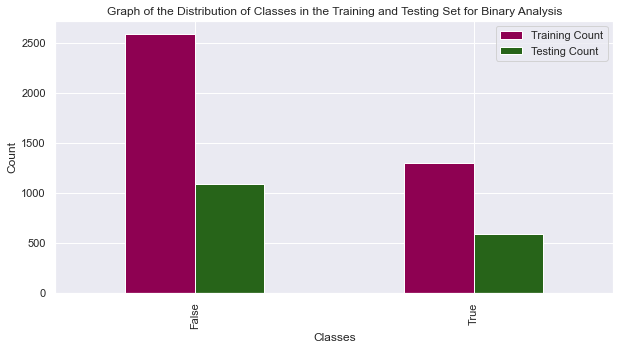

In [30]:
ax = class_dis2.plot.bar(figsize=[10,5],cmap='PiYG')
#ax.figure(figsize=[10,8])
ax.set_ylabel('Count')
ax.set_xlabel('Classes')
ax.set_title("Graph of the Distribution of Classes in the Training and Testing Set for Binary Analysis")
#ax.figure.savefig("Training and testing distribution 2 class graph.png",transparent=False,bbox_inches='tight')


# Rebalance the Classes

In [31]:
df_majority = train[train['Veracity']=='False']
df_minority_true = train[train['Veracity']=='True']

In [32]:
df_minority_upsampled_true = resample(df_minority_true,
                                   replace = True,
                                   n_samples =   2592)

In [33]:
df_upsampled = pd.concat([df_minority_upsampled_true,df_majority])


In [34]:
# Check it worked- debugging
print("The Percentage of classes are:")
print(df_upsampled['Veracity'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\n")
print("The Number of classes are:")
print(df_upsampled['Veracity'].value_counts())

The Percentage of classes are:
True     50.0%
False    50.0%
Name: Veracity, dtype: object


The Number of classes are:
True     2592
False    2592
Name: Veracity, dtype: int64


In [35]:
train = df_upsampled

In [36]:
# Final debugging before model implementation
train_text = train["Text"].tolist()
train_veracity = train["Veracity"].tolist()

test_text = test["Text"].tolist()
test_veracity = test["Veracity"].tolist()

# Check lengths
print(len(train_text))
print(len(train_veracity))

print(len(test_text))
print(len(test_veracity))

5184
5184
1666
1666


# Step 5: Model Implementation

# Model 1: Multinomial Naives Bayes

In [37]:
# This creates Tf-Idf Vector, then feeds into the multinomial naive bayes.

model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1.fit(train_text, train_veracity) # Train 

predicted_categories = model1.predict(test_text) # Predict 

print("Predicted Veracity:",predicted_categories.tolist()[0:5]) # First 5 predictions
print("Ground truth veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground truth veracity: ['False', 'False', 'False', 'False', 'False'] 



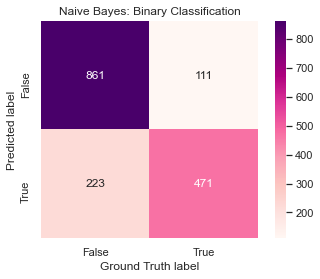

Accuracy:	0.799520
F1-score:	0.787897
Precision:	0.782238
Recall:		0.801779

 Classification performance:
              precision    recall  f1-score   support

       False       0.89      0.79      0.84      1084
        True       0.68      0.81      0.74       582

    accuracy                           0.80      1666
   macro avg       0.78      0.80      0.79      1666
weighted avg       0.81      0.80      0.80      1666



In [76]:
#Plot the confusion matrix 
mat1 = confusion_matrix(test_veracity, predicted_categories)
sns.heatmap(mat1.T, square = True, xticklabels = ["False","True"], yticklabels = ["False","True"],annot=True, fmt = "d",cmap="RdPu")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("Naive Bayes: Binary Classification")
#plt.savefig("Model 1- Multinomial Naive Bayes 2 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories))


# Model 2- K-Nearest Neighbour

In [39]:
# Creates numeric vector, feeds into KNN
model3 = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=27))
model3.fit(train_text, train_veracity) # Train 

predicted_categories3 = model3.predict(test_text) # Predict 

print("Predicted Veracity:",predicted_categories3.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'True', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'False', 'False', 'False', 'False'] 



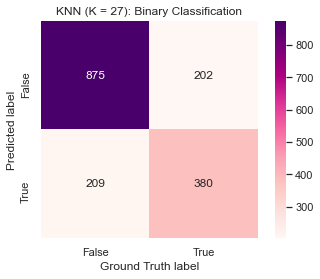

Accuracy:	0.753301
F1-score:	0.729414
Precision:	0.728802
Recall:		0.730058

 Classification performance:
              precision    recall  f1-score   support

       False       0.81      0.81      0.81      1084
        True       0.65      0.65      0.65       582

    accuracy                           0.75      1666
   macro avg       0.73      0.73      0.73      1666
weighted avg       0.75      0.75      0.75      1666



In [78]:
mat3 = confusion_matrix(test_veracity, predicted_categories3)
sns.heatmap(mat3.T, square = True,xticklabels = ["False","True"], yticklabels = ["False","True"],annot=True, fmt = "d",cmap="RdPu")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("KNN (K = 27): Binary Classification")
#plt.savefig("Model 3- KNN 2 Class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories3))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories3, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories3, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories3))


# Model 3- SVM

In [41]:
model4 = make_pipeline(TfidfVectorizer(), svm.SVC(kernel='linear'))
model4.fit(train_text, train_veracity) # Train 

predicted_categories4 = model4.predict(test_text) # Predict

print("Predicted Veracity:",predicted_categories4.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'False', 'False', 'False', 'False'] 



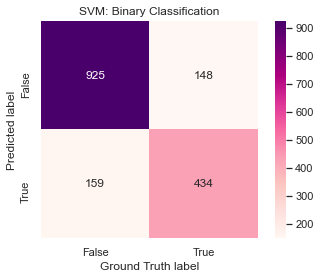

Accuracy:	0.815726
F1-score:	0.798198
Precision:	0.796970
Recall:		0.799513

 Classification performance:
              precision    recall  f1-score   support

       False       0.86      0.85      0.86      1084
        True       0.73      0.75      0.74       582

    accuracy                           0.82      1666
   macro avg       0.80      0.80      0.80      1666
weighted avg       0.82      0.82      0.82      1666



In [79]:
#Plot the confusion matrix 
mat4 = confusion_matrix(test_veracity, predicted_categories4)
sns.heatmap(mat4.T, square = True,xticklabels = ["False","True"], yticklabels = ["False","True"],annot=True, fmt = "d",cmap="RdPu")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("SVM: Binary Classification")
#plt.savefig("ModeL 4- SVM 2 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories4))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories4, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories4, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories4, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories4))


# Model 4- Decision Tree

In [43]:
model5 = make_pipeline(TfidfVectorizer(), tree.DecisionTreeClassifier(criterion='gini'))
model5.fit(train_text, train_veracity) # Train

predicted_categories5 = model5.predict(test_text) # Predict

print("Predicted Veracity:",predicted_categories5.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values



Predicted Veracity: ['False', 'True', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'False', 'False', 'False', 'False'] 



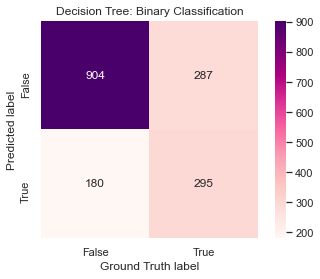

Accuracy:	0.719688
F1-score:	0.676454
Precision:	0.690039
Recall:		0.670411

 Classification performance:
              precision    recall  f1-score   support

       False       0.76      0.83      0.79      1084
        True       0.62      0.51      0.56       582

    accuracy                           0.72      1666
   macro avg       0.69      0.67      0.68      1666
weighted avg       0.71      0.72      0.71      1666



In [81]:
mat5 = confusion_matrix(test_veracity, predicted_categories5)
sns.heatmap(mat5.T, square = True,xticklabels = ["False","True"], yticklabels = ["False","True"],annot=True, fmt = "d",cmap="RdPu")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("Decision Tree: Binary Classification")
#plt.savefig("Model 5- Decision Tree 2 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories5))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories5, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories5, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories5, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories5))


# Model 5- Random Forest (100 Trees)

In [45]:
model6 = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100))
model6.fit(train_text, train_veracity) # Train

predicted_categories6 = model6.predict(test_text) # Predict

print("Predicted Veracity:",predicted_categories6.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'False', 'False', 'False', 'False'] 



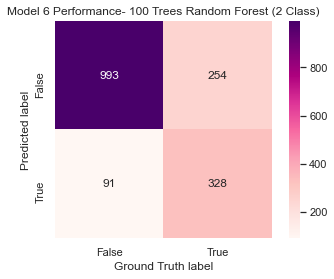

Accuracy:	0.792917
F1-score:	0.753670
Precision:	0.789564
Recall:		0.739813

 Classification performance:
              precision    recall  f1-score   support

       False       0.80      0.92      0.85      1084
        True       0.78      0.56      0.66       582

    accuracy                           0.79      1666
   macro avg       0.79      0.74      0.75      1666
weighted avg       0.79      0.79      0.78      1666



In [46]:
mat6 = confusion_matrix(test_veracity, predicted_categories6)
sns.heatmap(mat6.T, square = True,xticklabels = ["False","True"], yticklabels = ["False","True"],annot=True, fmt = "d",cmap="RdPu")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("Model 6 Performance- 100 Trees Random Forest (2 Class)")
#plt.savefig("Model 6- 100 Random forest 2 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories6))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories6, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories6, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories6, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories6))


# Model 6- Random Forest (1000) trees

In [47]:
model7 = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=1000))
model7.fit(train_text, train_veracity) # Train

predicted_categories7 = model7.predict(test_text) # Predict

print("Predicted Veracity:",predicted_categories7.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'False', 'False', 'False', 'False'] 



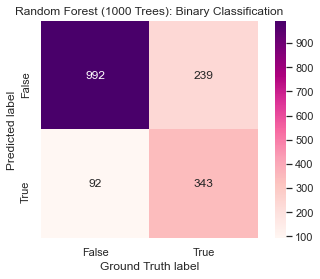

Accuracy:	0.801321
F1-score:	0.765776
Precision:	0.797177
Recall:		0.752238

 Classification performance:
              precision    recall  f1-score   support

       False       0.81      0.92      0.86      1084
        True       0.79      0.59      0.67       582

    accuracy                           0.80      1666
   macro avg       0.80      0.75      0.77      1666
weighted avg       0.80      0.80      0.79      1666



In [83]:
mat7 = confusion_matrix(test_veracity, predicted_categories7)
sns.heatmap(mat7.T, square = True,xticklabels = ["False","True"], yticklabels = ["False","True"],annot=True, fmt = "d",cmap="RdPu")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("Random Forest (1000 Trees): Binary Classification")
#plt.savefig("Model 7- 1000 Random Forest 2 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories7))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories7, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories7, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories7, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories7))


# Model 8- Neural Network LSTM

This model was formulated with guidance from Kasliwal, N. (2018). Natural Language Processing with Python Quick Start Guide (1st ed.). Van Haren Publishing

In [49]:
training_nn = pd.DataFrame({"Text":train_text, "Veracity":train_veracity})
training_nn.to_csv('training_nn.csv',index=False)
print(training_nn.head())

                                                Text Veracity
0  tonight thenine speak tom hancock last british...     True
1    china struggle return work coronavirus shutdown     True
2  coronavirus everywhere book flight take trip p...     True
3  princes george louis princess charlotte show a...     True
4  dog test positive coronavirus hong kong first ...     True


In [50]:
max_words = 0
for j in train_text:
    max_words = max(len(j.split()), max_words) 

print(max_words) #This shows the maximum number of words in a text, so we know the longest. 

71


In [51]:
import torch
import torchtext
from torchtext.legacy import data #For handling text data
import torch.nn as nn
import torch.optim as optim

In [52]:
#For LSTM, set it to include_lengths = False and fixed_lengths = True
TEXT = data.Field(tokenize=word_tokenize,batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)
fields = [('text',TEXT),('label', LABEL)]
dataset = data.TabularDataset(path = "training_nn.csv", format = "csv", fields = fields, skip_header = True)


In [53]:
training_data, validation_data = dataset.split(split_ratio=0.7) #Splitting the dat 70 for training, 30 for testing
 
# Building an object that splits text and labels
TEXT.build_vocab(training_data, min_freq = 1) #Minimum frequency has to be 1. 
LABEL.build_vocab(training_data)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
BatchSize = 32 # Bengio (2012) recommends 32
training_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, validation_data),
    batch_size = BatchSize,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

Device: cpu


In [54]:
print("Size of Text:",len(TEXT.vocab)) # Number of tokens in vocabulary
print("Size of Veracity:",len(LABEL.vocab),"\n") # Number of labels
print("Most common tokens:",TEXT.vocab.freqs.most_common(5),"\n") # Print the 5 most common in the training set

print("Number for unknown word:",TEXT.vocab.stoi['<unk>']) 
print("Number for padding word:",TEXT.vocab.stoi['<pad>'])

print("Number assigned to veracity:", LABEL.vocab.stoi) #Number assigned to veracity labels


Size of Text: 5918
Size of Veracity: 2 

Most common tokens: [('coronavirus', 1888), ('covid-19', 517), ('china', 482), ('virus', 407), ('people', 398)] 

Number for unknown word: 0
Number for padding word: 1
Number assigned to veracity: defaultdict(None, {'False': 0, 'True': 1})


In [55]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
        bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout, 
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()
    
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc1(hidden)
        outputs=self.act(dense_outputs)
        return outputs
    
# Inputs
vocabulary_size = len(TEXT.vocab) #Length of vocab
embedding_dim = 100 
LSTM_nodes = 28 #28 hidden nodes
LSTM_layers = 2 # Recommended by Thoma (2015) 
LSTM_bidirection = True
LSTM_dropout = 0.5 # Recommended by Rao and McMahan (2019)
output = 1 #Output size is 1

# Create Model
LSTM_classification = LSTM(vocabulary_size, embedding_dim, LSTM_nodes,
    output, LSTM_layers,
    bidirectional = LSTM_bidirection,dropout = LSTM_dropout)

# Printing LSTM Model archiecture
print(LSTM_classification)

def parameters(model):
    return sum(p.numel() for p in LSTM_classification .parameters() if p.requires_grad)
print("\n The number of LSTM trainable parameters:",parameters(LSTM_classification))


LSTM(
  (embedding): Embedding(5918, 100)
  (lstm): LSTM(100, 28, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=56, out_features=1, bias=True)
  (act): Sigmoid()
)

 The number of LSTM trainable parameters: 640241


In [56]:
import torch.optim as optim
optimizer = optim.Adam(LSTM_classification.parameters()) # Use the Adam optimiser
criterion = nn.BCELoss()

def binary_pred(preds, y):
    rounded_preds = torch.round(preds) # Round predictions
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

LSTM_classification = LSTM_classification.to(device)
criterion = criterion.to(device)


def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() # Set the model in training phase
    for batch in iterator:
        optimizer.zero_grad() # Reset the gradients after every batch
        text, text_lengths = batch.text # Retrieve text and number of words 
        predictions = model(text, text_lengths).squeeze() # Convert to 1D tensor
        loss = criterion(predictions, batch.label) # Compute the loss
        acc = binary_pred(predictions, batch.label) # Compute the binary accuracy 
        loss.backward() # Backpropagation
        optimizer.step() # Update the weights
        # Update epoch's loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval() # Set the model in evaluation phase
    with torch.no_grad(): #Deactivates autograd
        for batch in iterator:
            text, text_lengths = batch.text # Retrieve text and number of words 
            predictions = model(text, text_lengths).squeeze() # Convert to 1d tensor 
            loss = criterion(predictions, batch.label) # Compute loss and accuracy 
            acc = binary_pred(predictions, batch.label)
            # Update epoch's loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [57]:
import time

Epochs = 5

# Training the model over 5 epochs
for epoch in range(Epochs):
    print("Epoch %3d:" % epoch,end='')
    start = time.time()
    train_loss, train_acc = train(LSTM_classification, training_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(LSTM_classification, test_iterator, criterion)

    print(" Train loss: %.3f | Train acuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation acuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))



Epoch   0: Train loss: 0.679 | Train acuracy: 0.5890 | Validation loss: 0.625 | Validation acuracy: 0.6628 - 3.63 s
Epoch   1: Train loss: 0.500 | Train acuracy: 0.7651 | Validation loss: 0.466 | Validation acuracy: 0.7858 - 4.51 s
Epoch   2: Train loss: 0.326 | Train acuracy: 0.8679 | Validation loss: 0.417 | Validation acuracy: 0.8309 - 3.90 s
Epoch   3: Train loss: 0.212 | Train acuracy: 0.9235 | Validation loss: 0.385 | Validation acuracy: 0.8488 - 3.28 s
Epoch   4: Train loss: 0.152 | Train acuracy: 0.9420 | Validation loss: 0.422 | Validation acuracy: 0.8546 - 3.28 s


In [58]:
def LSTM_predict(model, sentence):
    tokenised = [token for token in word_tokenize(sentence)] # Tokenise text
    indexed = [TEXT.vocab.stoi[token] for token in tokenised]
    length = [len(indexed)] 
    tensor = torch.LongTensor(indexed).to(device) 
    tensor = tensor.unsqueeze(1).T 
    length_tensor = torch.LongTensor(length) 
    prediction = model(tensor, length_tensor) 
    return int(round(prediction.item()))


label_names = {0:"False",1:"True"}
#{'False': 0, 'True': 1})

prediction3 = []
for i in test_text:
    predict_label = label_names[LSTM_predict(LSTM_classification, i)]
    prediction3.append(predict_label)
    
print("Predicted Veracity:",prediction3[0:5])
print("Ground Truth Veracity:",test_veracity[0:5])

Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground Truth Veracity: ['False', 'False', 'False', 'False', 'False']


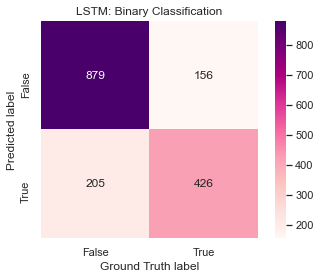

Accuracy:	0.783313
F1-score:	0.766014
Precision:	0.762197
Recall:		0.771422

 Classification performance:
              precision    recall  f1-score   support

       False       0.85      0.81      0.83      1084
        True       0.68      0.73      0.70       582

    accuracy                           0.78      1666
   macro avg       0.76      0.77      0.77      1666
weighted avg       0.79      0.78      0.79      1666



In [84]:
mat8 = confusion_matrix(test_veracity, prediction3)
sns.heatmap(mat8.T, square = True,xticklabels = ["False","True"], yticklabels = ["False","True"], annot=True, fmt = "d",cmap="RdPu")

plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
#plt.title("LSTM: Binary Classification")
plt.savefig("Model 8- LSTM 2 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, prediction3))
print("F1-score:\t%f" % f1_score(test_veracity, prediction3, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, prediction3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, prediction3, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, prediction3))


# Model 9- CNN

Model guided by Trevett, B. (2021). pytorch-sentiment-analysis/4 - Convolutional Sentiment Analysis.ipynb at master · bentrevett/pytorch-sentiment-analysis. GitHub. Retrieved 20 May 2022, from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

In [60]:
max_words = 0
for sentence in train_text :
    max_words = max(len(sentence.split()), max_words ) 

print(max_words) 

71


In [61]:
# For CNN, using the argument fix_length which is the maximum sentence length
# for padding purposes.
TEXT = data.Field(tokenize=word_tokenize,batch_first=True, fix_length = max_words)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)
fields = [('text',TEXT),('label', LABEL)]
dataset = data.TabularDataset(path = "training_nn.csv", format = "csv", fields = fields, skip_header = True)


In [62]:
training_data, validation_data = dataset.split(split_ratio=0.7)

# Build the vocab and labels, where they must occur at least once.
TEXT.build_vocab(training_data, min_freq = 1)
LABEL.build_vocab(training_data)

In [63]:
print("Size of text vocabulary:",len(TEXT.vocab)) 
print("Size of label vocabulary:",len(LABEL.vocab),"\n") 
print("Most common tokens:",TEXT.vocab.freqs.most_common(5),"\n")

print("Number for unknown word :",TEXT.vocab.stoi['<unk>']) 
print("Number for padding word :",TEXT.vocab.stoi['<pad>'])
#Print the lablel keys which are needed later when predicting.
print("Veracity labels:", LABEL.vocab.stoi)

Size of text vocabulary: 5918
Size of label vocabulary: 2 

Most common tokens: [('coronavirus', 1888), ('covid-19', 517), ('china', 482), ('virus', 407), ('people', 398)] 

Number for unknown word : 0
Number for padding word : 1
Veracity labels: defaultdict(None, {'False': 0, 'True': 1})


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
BatchSize = 32
training_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, validation_data),
    batch_size = BatchSize,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

Device: cpu


In [70]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, n_filters,
                filter_sizes, pad_idx, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels = embedding_dim, out_channels = n_filters,
                      kernel_size = f, padding = 'same') for f in filter_sizes])
        
        self.maxpool1d = nn.MaxPool1d(2, stride = 2)
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters,output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.permute(0,2,1)
        conved = [F.relu(conv(embedded)) for conv in self.conv_layers]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.fc(cat)
        
# Inputs
vocab_size = len(TEXT.vocab) # Length of Vocab
embedding_dim = 100 # Embedding Dimension of 100
output = 1 #Output size is 1
n_filters = 100 #There are 100 filters
filter_sizes = [2,3,4] #Bi-gram, Tri-gram and Four-gram. Recommended by Rao and McMahan (2019) 
pad_idx = TEXT.vocab.stoi[TEXT.pad_token] #Set padding to 1
dropout = 0.5 #Dropout rate of 0.5
    
CNN_classification = CNN(vocab_size, 
            embedding_dim,
            output,
            n_filters,
            filter_sizes,
            pad_idx,
            dropout)

#Printing the model architecture
print(CNN_classification)
def parameters(model):
    return sum(p.numel() for p in CNN_classification.parameters() if p.requires_grad)
print("\n CNN model trainable parameters:",parameters(CNN_classification))


CNN(
  (embedding): Embedding(5918, 100, padding_idx=1)
  (conv_layers): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=same)
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,), padding=same)
  )
  (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

 CNN model trainable parameters: 682401


In [71]:
optimizer = torch.optim.Adam(CNN_classification.parameters()) 
criterion  = nn.BCEWithLogitsLoss() # Use binary cross entropy loss as loss fucntion

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


CNN_classification = CNN_classification.to(device)
criterion = criterion.to(device)

In [72]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

Epochs = 6 # 6 epochs

for epoch in range(Epochs):
    print("Epoch %3d:" % epoch,end='')
    start = time.time()
    train_loss, train_acc = train(CNN_classification, training_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(CNN_classification, test_iterator, criterion)
    print(" Train loss: %.3f | Train acuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation acuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))


Epoch   0: Train loss: 0.652 | Train acuracy: 0.6180 | Validation loss: 0.541 | Validation acuracy: 0.7374 - 7.51 s
Epoch   1: Train loss: 0.476 | Train acuracy: 0.7777 | Validation loss: 0.458 | Validation acuracy: 0.7842 - 6.98 s
Epoch   2: Train loss: 0.342 | Train acuracy: 0.8647 | Validation loss: 0.392 | Validation acuracy: 0.8391 - 6.73 s
Epoch   3: Train loss: 0.246 | Train acuracy: 0.9139 | Validation loss: 0.345 | Validation acuracy: 0.8582 - 6.93 s
Epoch   4: Train loss: 0.173 | Train acuracy: 0.9441 | Validation loss: 0.342 | Validation acuracy: 0.8493 - 6.60 s
Epoch   5: Train loss: 0.132 | Train acuracy: 0.9566 | Validation loss: 0.346 | Validation acuracy: 0.8520 - 6.63 s


In [73]:
def predict_CNN(model, sentence, min_len = max_words):
    tokenised = [token for token in word_tokenize(sentence)] # Tokenise text
    if len(tokenised) < min_len:
        tokenised+= ['<pad>'] * (min_len - len(tokenised))
    
    indexed = [TEXT.vocab.stoi[token] for token in tokenised] 
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = model(tensor)
    prediction = torch.sigmoid(model(tensor))
    return int(round(prediction.item()))


# Ensuring labels for neurals match up with the correct labels to predict veracity
label_names = {0:'False',1:'True'}

prediction9 = []

for i in test_text:
    predict_label = label_names[predict_CNN(CNN_classification, i)]
    prediction9.append(predict_label)
    
print("Predicted Veracity:",prediction9[0:5])
print("Ground Truth Veracity:",test_veracity[0:5])


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground Truth Veracity: ['False', 'False', 'False', 'False', 'False']


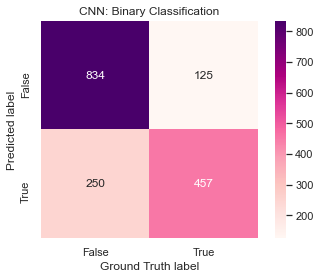

Accuracy:	0.774910
F1-score:	0.762762
Precision:	0.758025
Recall:		0.777298

 Classification performance:
              precision    recall  f1-score   support

       False       0.87      0.77      0.82      1084
        True       0.65      0.79      0.71       582

    accuracy                           0.77      1666
   macro avg       0.76      0.78      0.76      1666
weighted avg       0.79      0.77      0.78      1666



In [86]:
mat9 = confusion_matrix(test_veracity, prediction9)
sns.heatmap(mat9.T, square = True ,xticklabels = ["False","True"], yticklabels = ["False","True"], annot=True, fmt = "d",cmap="RdPu")

plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("CNN: Binary Classification")
#plt.savefig("Model 9- CNN 2 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, prediction9))
print("F1-score:\t%f" % f1_score(test_veracity, prediction9, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, prediction9, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, prediction9, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, prediction9))
